In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install catboost

In [340]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from sklearn.impute import SimpleImputer
from scipy import stats
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

In [341]:
import warnings
warnings.filterwarnings('ignore')

In [342]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score
from sklearn.model_selection import cross_validate
from sklearn import tree
from sklearn.metrics import classification_report

def eval_classification(model):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)
    
    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))
    
    print("roc_auc (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("roc_auc (train-proba): %.2f" % roc_auc_score(y_train, y_pred_proba_train[:, 1]))

    score = cross_validate(model, X, y, cv=5, scoring='roc_auc', return_train_score=True)
    print('roc_auc (crossval train): '+ str(score['train_score'].mean()))
    print('roc_auc (crossval test): '+ str(score['test_score'].mean()))

def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

def show_best_hyperparameter(model):
    print(model.best_estimator_.get_params())

In [343]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
import catboost as cb

def draw_learning_curve(param_values):
    train_scores = []
    test_scores = []

    for c in param_values:
        model = LogisticRegression(penalty='l2', C=c)
        model.fit(X_train, y_train)

        # eval on train
        y_pred_train_proba = model.predict_proba(X_train)
        train_auc = roc_auc_score(y_train, y_pred_train_proba[:,1])
        train_scores.append(train_auc)

        # eval on test
        y_pred_proba = model.predict_proba(X_test)
        test_auc = roc_auc_score(y_test, y_pred_proba[:,1])
        test_scores.append(test_auc)

        print('param value: ' + str(c) + '; train: ' + str(train_auc) + '; test: '+ str(test_auc))

    plt.plot(param_values, train_scores, label='Train')
    plt.plot(param_values, test_scores, label='Test')
    plt.xlabel('C')
    plt.ylabel('AUC')
    plt.title('Learning Curve - Hyperparameter C - Logistic Regression')
    plt.legend()
    plt.show()

In [344]:
df = pd.read_excel('E Commerce Dataset.xlsx', sheet_name='outlier, tanpa transformasi', index_col=0)
df.sample(5)

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,Gender,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,...,PreferredPaymentMode_E wallet,PreferredPaymentMode_UPI,PreferedOrderCat_Fashion,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Others,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
5199,55200,1,1,1,2,16,0,3,4,3,...,0,0,0,0,0,1,0,0,1,0
2171,52172,0,11,1,2,6,1,3,1,3,...,0,1,0,0,0,1,0,0,1,0
3915,53916,0,19,1,1,35,0,3,5,4,...,0,0,0,1,0,0,0,0,0,1
923,50924,0,7,1,3,9,1,2,5,5,...,0,1,0,0,1,0,0,0,0,1
1406,51407,0,11,0,1,14,0,2,3,1,...,0,0,0,0,1,0,0,0,0,1


In [345]:
X = df.drop(columns=['OrderCount','MaritalStatus_Married','CustomerID', 'Churn'])
y = df['Churn']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [346]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
def get_metrics(y_pred, y_act, model_name):
    recall =  recall_score(y_act, y_pred)
    precision = precision_score(y_act, y_pred)
    roc_auc = roc_auc_score(y_act, y_pred)
    f1 = f1_score(y_act, y_pred)
    accuracy = balanced_accuracy_score(y_act, y_pred)

    metrics_result = dict(model_name=model_name, 
                        recall=recall, 
                        precision=precision, 
                        roc_auc=roc_auc, 
                        f1=f1,
                        accuracy=accuracy)
    return metrics_result


def prediction(X_train, y_train, X_test, y_test, clf, model_name='decision tree'):
  
    clf = clf
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    y_train_pred = clf.predict(X_train)


    result = dict()
    test_result = get_metrics(y_pred=y_test_pred, y_act=y_test, model_name=model_name)
    train_result = get_metrics(y_pred=y_train_pred, y_act=y_train, model_name=model_name)

    result['test'] = test_result
    result['train'] = train_result
    result['y_test'] = y_test
    result['y_test_pred'] = y_test_pred
    result['y_train'] = y_train
    result['y_train_pred'] = y_train_pred
    result['clf'] = clf
    result['x_train'] = X_train
    result['x_test'] = X_test

    del clf

    return result
  
def show_best_hyperparameter(model, hyperparameters):
    for key, value in hyperparameters.items() :
        print('Best '+key+':', model.get_params()[key])

def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=x.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

In [347]:
model_1_result = prediction(X_train, y_train, X_test, y_test, LogisticRegression(), model_name='logistic regression')
model_2_result = prediction(X_train, y_train, X_test, y_test, RandomForestClassifier(random_state=42), model_name='random forest')
model_3_result = prediction(X_train, y_train, X_test, y_test, KNeighborsClassifier(), model_name='kNN')
model_4_result = prediction(X_train, y_train, X_test, y_test, tree.DecisionTreeClassifier(), model_name='decision tree')
model_5_result = prediction(X_train, y_train, X_test, y_test, AdaBoostClassifier(random_state=42), model_name='adaboost')
model_6_result = prediction(X_train, y_train, X_test, y_test, xgb.XGBClassifier(random_state=42), model_name='xgboost')
model_7_result = prediction(X_train, y_train, X_test, y_test, cb.CatBoostClassifier(random_state=42, logging_level='Silent'), model_name='catboost')

### TRAIN

In [348]:
pd.DataFrame([model_1_result['train'], 
              model_2_result['train'], 
              model_3_result['train'], 
              model_4_result['train'], 
              model_5_result['train'],
              model_6_result['train'],
              model_7_result['train']])

,model_name,recall,precision,roc_auc,f1,accuracy
0,logistic regression,0.496723,0.749012,0.731388,0.597321,0.731388
1,random forest,1.000000,1.000000,1.000000,1.000000,1.000000
2,kNN,0.553080,0.791745,0.761704,0.651235,0.761704
3,decision tree,1.000000,1.000000,1.000000,1.000000,1.000000
4,adaboost,0.579292,0.772727,0.772271,0.662172,0.772271
5,xgboost,1.000000,1.000000,1.000000,1.000000,1.000000
6,catboost,0.956750,0.997268,0.978108,0.976589,0.978108


### TEST

In [349]:
pd.DataFrame([model_1_result['test'], 
              model_2_result['test'], 
              model_3_result['test'], 
              model_4_result['test'], 
              model_5_result['test'],
              model_6_result['test'], 
              model_7_result['test']])

,model_name,recall,precision,roc_auc,f1,accuracy
0,logistic regression,0.524324,0.815126,0.750472,0.638158,0.750472
1,random forest,0.859459,1.000000,0.929730,0.924419,0.929730
2,kNN,0.421622,0.634146,0.686900,0.506494,0.686900
3,decision tree,0.924324,0.904762,0.952598,0.914439,0.952598
4,adaboost,0.567568,0.833333,0.772625,0.675241,0.772625
5,xgboost,0.886486,0.976190,0.941118,0.929178,0.941118
6,catboost,0.821622,0.987013,0.909748,0.896755,0.909748


In [350]:
print(classification_report(model_4_result['y_test'], model_4_result['y_test_pred']))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       941
           1       0.90      0.92      0.91       185

    accuracy                           0.97      1126
   macro avg       0.94      0.95      0.95      1126
weighted avg       0.97      0.97      0.97      1126



## Hyperparameter Tuning

### Hyperparameter LogisticRegression

In [351]:
logres = LogisticRegression()
logres.fit(X_train, y_train)
print('Train score: ' + str(logres.score(X_train, y_train))) #accuracy
print('Test score:' + str(logres.score(X_test, y_test))) #accuracy

Train score: 0.8865452930728241
Test score:0.9023090586145648


In [352]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# List Hyperparameters yang akan diuji
penalty = ['l2','l1','elasticnet']
C = [0.0001, 0.001, 0.002] # Inverse of regularization strength; smaller values specify stronger regularization.
hyperparameters = dict(penalty=penalty, C=C)

# Inisiasi model
logres = LogisticRegression(random_state=42) # Init Logres dengan Gridsearch, cross validation = 5
logres_tuned = RandomizedSearchCV(logres, hyperparameters, cv=5, random_state=42, scoring='recall')

# Fitting Model & Evaluation
logres_hyper = prediction(X_train, y_train, X_test, y_test, logres_tuned, model_name='logistic regression_hyperparam')

In [353]:
print('Best algorithm:', logres_tuned.best_estimator_.get_params()['penalty'])
print('Best C:', logres_tuned.best_estimator_.get_params()['C'])

Best algorithm: l2
Best C: 0.002


In [354]:
print('Train score: ' + str(logres_tuned.score(X_train, y_train))) #recall
print('Test score: ' + str(logres_tuned.score(X_test, y_test))) #recall

Train score: 0.2608125819134993
Test score: 0.3027027027027027


### Hyperparameter KNN

In [355]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print('Train score: ' + str(knn.score(X_train, y_train))) #recall
print('Test score:' + str(knn.score(X_test, y_test))) #recall

Train score: 0.8996447602131439
Test score:0.8650088809946714


In [356]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# List of hyperparameter
n_neighbors = list(range(1,30))
p=[1,2]
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
hyperparameters = dict(n_neighbors=n_neighbors, p=p, algorithm=algorithm)

# Init model
knn = KNeighborsClassifier()
knn_tuned = RandomizedSearchCV(knn, hyperparameters, cv=5, random_state=42, scoring='recall')

# Fit Model & Evaluasi
kkn_hyper = prediction(X_train, y_train, X_test, y_test, knn_tuned, model_name='kNN_hyperparam')

In [357]:
print('Best n_neighbors:', knn_tuned.best_estimator_.get_params()['n_neighbors'])
print('Best p:', knn_tuned.best_estimator_.get_params()['p'])
print('Best algorithm:', knn_tuned.best_estimator_.get_params()['algorithm'])

Best n_neighbors: 5
Best p: 1
Best algorithm: ball_tree


In [358]:
print('Train score: ' + str(knn_tuned.score(X_train, y_train))) #recall
print('Test score: ' + str(knn_tuned.score(X_test, y_test))) #recall

Train score: 0.6041939711664482
Test score: 0.4648648648648649


### Hyperparameter DecisionTreeClassifier

In [359]:
dt = tree.DecisionTreeClassifier() 
dt.fit(X_train,y_train)
print('Train score: ' + str(dt.score(X_train, y_train))) #recall
print('Test score:' + str(dt.score(X_test, y_test))) #recall

Train score: 1.0
Test score:0.9680284191829485


In [360]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
import numpy as np

# List of hyperparameter
max_depth = [int(x) for x in np.linspace(1, 110, num = 30)] # Maximum number of levels in tree
min_samples_split = [2, 5, 10, 100] # Minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4, 10, 20, 50] # Minimum number of samples required at each leaf node
max_features = ['auto', 'sqrt'] # Number of features to consider at every split

hyperparameters = dict(max_depth=max_depth, 
                       min_samples_split=min_samples_split, 
                       min_samples_leaf=min_samples_leaf,
                       max_features=max_features
                      )

# Inisialisasi Model
dt = tree.DecisionTreeClassifier()
dt_tuned = RandomizedSearchCV(dt, hyperparameters, cv=5, random_state=42, scoring='recall')

# Predict & Evaluation
dt_hyper = prediction(X_train, y_train, X_test, y_test, dt_tuned, model_name='decision tree_hyperparam')

In [361]:
print('Best max_depth:', dt_tuned.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', dt_tuned.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', dt_tuned.best_estimator_.get_params()['min_samples_leaf'])
print('Best max_features:', dt_tuned.best_estimator_.get_params()['max_features'])

Best max_depth: 87
Best min_samples_split: 10
Best min_samples_leaf: 1
Best max_features: sqrt


In [362]:
print('Train score: ' + str(dt_tuned.score(X_train, y_train))) #recall
print('Test score: ' + str(dt_tuned.score(X_test, y_test))) #recall

Train score: 0.8217562254259502
Test score: 0.654054054054054


### Hyperparameter Random Forest

In [363]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train,y_train)
print('Train score: ' + str(rf.score(X_train, y_train))) #recall
print('Test score: ' + str(rf.score(X_test, y_test))) #recall

Train score: 1.0
Test score: 0.9769094138543517


In [364]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#List Hyperparameters yang akan diuji
hyperparameters = dict(
                       n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)], # Jumlah subtree 
                       bootstrap = [True], # Apakah pakai bootstrapping atau tidak
                       criterion = ['gini','entropy'],
                       max_depth = [int(x) for x in np.linspace(10, 110, num = 11)],  # Maximum kedalaman tree
                       min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 10, num = 5)], # Jumlah minimum samples pada node agar boleh di split menjadi leaf baru
                       min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 10, num = 5)], # Jumlah minimum samples pada leaf agar boleh terbentuk leaf baru
                       max_features = ['auto', 'sqrt', 'log2'], # Jumlah feature yg dipertimbangkan pada masing-masing split
                       n_jobs = [-1], # Core untuk parallel computation. -1 untuk menggunakan semua core
                      )

# Init
rf = RandomForestClassifier(random_state=42)
rf_tuned = RandomizedSearchCV(rf, hyperparameters, cv=5, random_state=42, scoring='recall')

# Predict & Evaluation
rf_hyper = prediction(X_train, y_train, X_test, y_test, rf_tuned, model_name='random forest_hyperparam')

In [365]:
show_best_hyperparameter(rf_tuned.best_estimator_, hyperparameters)

Best n_estimators: 400
Best bootstrap: True
Best criterion: gini
Best max_depth: 110
Best min_samples_split: 4
Best min_samples_leaf: 1
Best max_features: log2
Best n_jobs: -1


In [366]:
print('Train score: ' + str(rf_tuned.score(X_train, y_train))) #recall
print('Test score: ' + str(rf_tuned.score(X_test, y_test))) #recall

Train score: 0.9973787680209698
Test score: 0.7945945945945946


### Hyperparameter AdaBoost

In [367]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import numpy as np

# List of hyperparameter
hyperparameters = dict(n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)], # Jumlah iterasi
                       learning_rate = [float(x) for x in np.linspace(start = 0.001, stop = 0.1, num = 20)],  
                       algorithm = ['SAMME', 'SAMME.R']
                      )

# Init model
ab = AdaBoostClassifier(random_state=42)
ab_tuned = RandomizedSearchCV(ab, hyperparameters, random_state=42, cv=5, scoring='recall')

# Predict & Evaluation
ad_hyper = prediction(X_train, y_train, X_test, y_test, ab_tuned, model_name='adaboost_hyperparam')

In [368]:
show_best_hyperparameter(ab_tuned.best_estimator_, hyperparameters)

Best n_estimators: 1700
Best learning_rate: 0.07394736842105264
Best algorithm: SAMME.R


In [369]:
print('Train score: ' + str(ab_tuned.score(X_train, y_train))) #recall
print('Test score: ' + str(ab_tuned.score(X_test, y_test))) #recall

Train score: 0.5950196592398427
Test score: 0.6


### Hyperparameter CatBoost

In [370]:
cat = cb.CatBoostClassifier(random_state=42, logging_level='Silent')
cat.fit(X_train,y_train)
print('Train score: ' + str(cat.score(X_train, y_train))) #recall
print('Test score: ' + str(cat.score(X_test, y_test))) #recall

Train score: 0.9922291296625222
Test score: 0.9689165186500888


In [371]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import numpy as np

# List of hyperparameter
hyperparameters = dict(n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)], # Jumlah iterasi
                       learning_rate = [float(x) for x in np.linspace(start = 0.001, stop = 0.1, num = 20)]
                      )

# Init model
cat = cb.CatBoostClassifier(random_state=42,logging_level='Silent')
cat_tuned = RandomizedSearchCV(cat, hyperparameters, random_state=42, cv=5, scoring='recall')

# Predict & Evaluation
cat_hyper = prediction(X_train, y_train, X_test, y_test, cat_tuned, model_name='cat boost_hyperparam')

In [372]:
show_best_hyperparameter(cat_tuned.best_estimator_, hyperparameters)

Best n_estimators: 1000
Best learning_rate: 0.08436842105263158


In [373]:
print('Train score: ' + str(cat_tuned.score(X_train, y_train))) #recall
print('Test score: ' + str(cat_tuned.score(X_test, y_test))) #recall

Train score: 1.0
Test score: 0.9135135135135135


### Hyperparameter XGBOOST

In [374]:
xg = xgb.XGBClassifier(random_state=42)
xg.fit(X_train, y_train)
print('Train score: ' + str(xg.score(X_train, y_train))) #recall
print('Test score: ' + str(xg.score(X_test, y_test))) #recall

Train score: 1.0
Test score: 0.977797513321492


In [375]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import numpy as np

#Menjadikan ke dalam bentuk dictionary
hyperparameters = {
                    'max_depth' : [int(x) for x in np.linspace(10, 110, num = 11)],
                    'min_child_weight' : [int(x) for x in np.linspace(1, 20, num = 11)],
                    'gamma' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'tree_method' : ['auto', 'exact', 'approx', 'hist'],

                    'colsample_bytree' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'eta' : [float(x) for x in np.linspace(0, 1, num = 100)],

                    'lambda' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'alpha' : [float(x) for x in np.linspace(0, 1, num = 11)]
                    }

# Init
xg = xgb.XGBClassifier(random_state=42)
xg_tuned = RandomizedSearchCV(xg, hyperparameters, cv=5, random_state=42, scoring='recall')

# Predict & Evaluation
xg_hyper = prediction(X_train, y_train, X_test, y_test, xg_tuned, model_name='xgboost_hyperparam')

In [376]:
show_best_hyperparameter(xg_tuned.best_estimator_, hyperparameters)

Best max_depth: 110
Best min_child_weight: 2
Best gamma: 0.5
Best tree_method: hist
Best colsample_bytree: 1.0
Best eta: 0.7777777777777778
Best lambda: 0.2
Best alpha: 0.1


In [377]:
print('Train score: ' + str(xg_tuned.score(X_train, y_train))) #recall
print('Test score: ' + str(xg_tuned.score(X_test, y_test))) #recall

Train score: 0.9986893840104849
Test score: 0.9297297297297298


## Result Hyperparameter modeling

In [378]:
pd.DataFrame([logres_hyper['train'], 
              kkn_hyper['train'], 
              dt_hyper['train'], 
              rf_hyper['train'], 
              ad_hyper['train'],
              cat_hyper['train'],
              xg_hyper['train']
              ])

,model_name,recall,precision,roc_auc,f1,accuracy
0,logistic regression_hyperparam,0.260813,0.771318,0.622521,0.389814,0.622521
1,kNN_hyperparam,0.604194,0.833635,0.789801,0.700608,0.789801
2,decision tree_hyperparam,0.821756,0.907381,0.902324,0.862448,0.902324
3,random forest_hyperparam,0.997379,1.000000,0.998689,0.998688,0.998689
4,adaboost_hyperparam,0.595020,0.766892,0.779066,0.670111,0.779066
5,cat boost_hyperparam,1.000000,1.000000,1.000000,1.000000,1.000000
6,xgboost_hyperparam,0.998689,1.000000,0.999345,0.999344,0.999345


In [379]:
pd.DataFrame([logres_hyper['test'], 
              kkn_hyper['test'], 
              dt_hyper['test'], 
              rf_hyper['test'], 
              ad_hyper['test'],
              cat_hyper['test'],
              xg_hyper['test']
              ])

,model_name,recall,precision,roc_auc,f1,accuracy
0,logistic regression_hyperparam,0.302703,0.848485,0.646038,0.446215,0.646038
1,kNN_hyperparam,0.464865,0.699187,0.712772,0.558442,0.712772
2,decision tree_hyperparam,0.654054,0.707602,0.800460,0.679775,0.800460
3,random forest_hyperparam,0.794595,0.993243,0.896766,0.882883,0.896766
4,adaboost_hyperparam,0.600000,0.816176,0.786716,0.691589,0.786716
5,cat boost_hyperparam,0.913514,0.994118,0.956225,0.952113,0.956225
6,xgboost_hyperparam,0.929730,0.955556,0.960614,0.942466,0.960614


## Confusion Matrix

In [482]:
# logisticRegression
y_pred = logres_tuned.predict(X_test)
y_pred_train = logres_tuned.predict(X_train)

In [438]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

print(cf_matrix)

[[931  10]
 [129  56]]


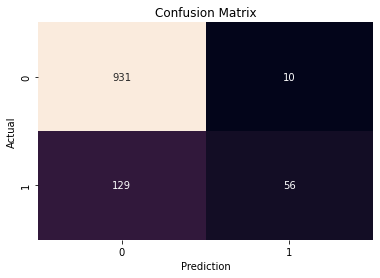

In [439]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cbar=False,fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Prediction')
plt.show()

In [440]:
# KNN
y_pred = knn_tuned.predict(X_test)
y_pred_train = knn_tuned.predict(X_train)

In [441]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

print(cf_matrix)

[[904  37]
 [ 99  86]]


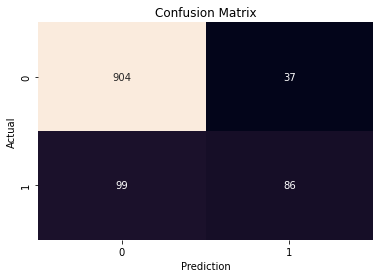

In [442]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cbar=False,fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Prediction')
plt.show()

In [481]:
# DecisionTree
y_pred = dt_tuned.predict(X_test)
y_pred_train = dt_tuned.predict(X_train)

In [444]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

print(cf_matrix)

[[891  50]
 [ 64 121]]


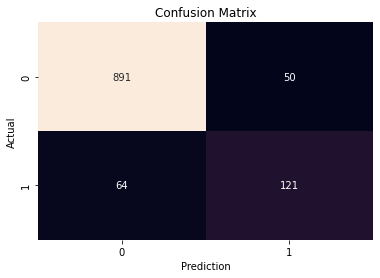

In [445]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cbar=False,fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Prediction')
plt.show()

In [446]:
# Catboost
y_pred = rf_tuned.predict(X_test)
y_pred_train = rf_tuned.predict(X_train)

In [447]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

print(cf_matrix)

[[940   1]
 [ 38 147]]


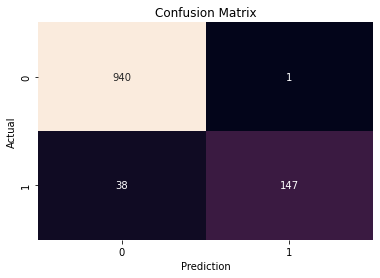

In [448]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cbar=False,fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Prediction')
plt.show()

In [479]:
# Adaboost
y_pred = ab_tuned.predict(X_test)
y_pred_train = ab_tuned.predict(X_train)

In [450]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

print(cf_matrix)

[[916  25]
 [ 74 111]]


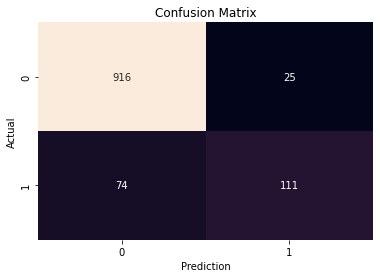

In [451]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cbar=False,fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Prediction')
plt.show()

In [452]:
# Catboost
y_pred = cat_tuned.predict(X_test)
y_pred_train = cat_tuned.predict(X_train)

In [453]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

print(cf_matrix)

[[940   1]
 [ 16 169]]


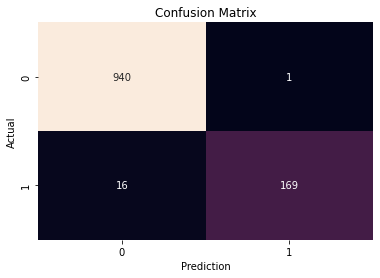

In [454]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cbar=False,fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Prediction')
plt.show()

In [480]:
# Xgboost
y_pred = xg_tuned.predict(X_test)
y_pred_train = xg_tuned.predict(X_train)

In [456]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

print(cf_matrix)

[[933   8]
 [ 13 172]]


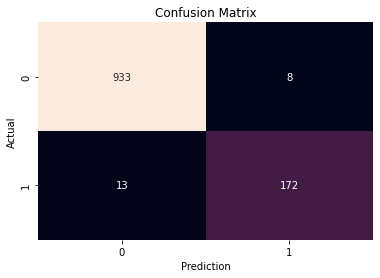

In [457]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cbar=False,fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Prediction')
plt.show()

## Feature Importance

In [458]:
import shap

In [459]:
# model interpretation CatBoost

explainer = shap.Explainer(cat_hyper['clf'].predict, cat_hyper['x_test'])
shap_values_cat = explainer(cat_hyper['x_test'])

Permutation explainer: 1127it [00:42, 20.42it/s]                                                                       


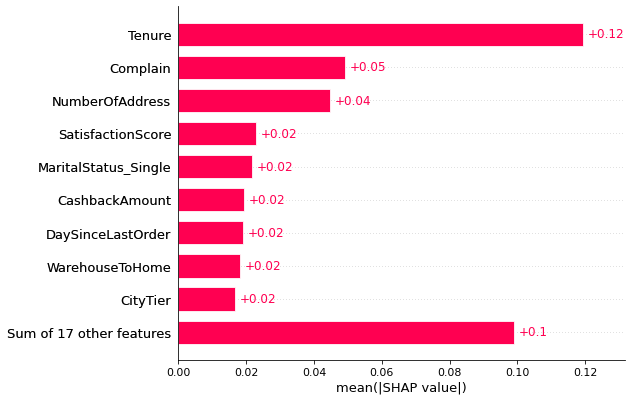

In [460]:
shap.plots.bar(shap_values_cat)

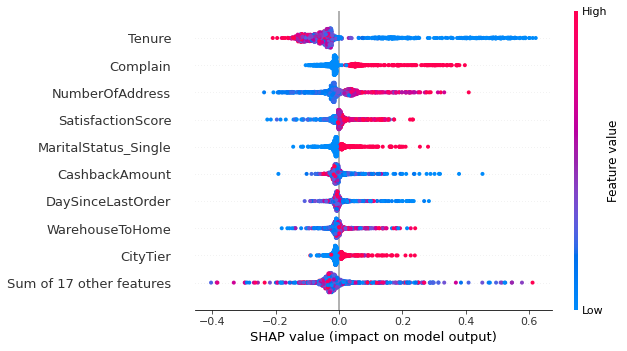

In [461]:
shap.plots.beeswarm(shap_values_cat)

## Top Feature Insight

In [462]:
df_featureinsight = pd.read_excel('E Commerce Dataset Cleaned.xlsx')
df_featureinsight.sample(5)

,Unnamed: 0,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,...,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
5125,5125,55126,0,1,Mobile Phone,1,26,Credit Card,Male,4,...,Mobile Phone,1,Married,5,0,12,1,2,3,161.69
5103,5103,55104,0,20,Mobile Phone,2,8,Debit Card,Female,3,...,Mobile Phone,5,Single,8,0,13,3,6,8,159.23
559,559,50560,0,13,Mobile Phone,3,16,E wallet,Male,3,...,Fashion,4,Married,3,0,12,1,1,0,197.05
1075,1075,51076,0,17,Mobile Phone,2,6,Debit Card,Female,2,...,Mobile Phone,1,Married,5,1,18,2,2,2,131.95
3200,3200,53201,0,28,Mobile Phone,2,26,Credit Card,Male,3,...,Fashion,4,Divorced,4,0,16,4,2,2,232.25


In [486]:
df_featureinsight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   5630 non-null   int64  
 1   CustomerID                   5630 non-null   int64  
 2   Churn                        5630 non-null   int64  
 3   Tenure                       5630 non-null   int64  
 4   PreferredLoginDevice         5630 non-null   object 
 5   CityTier                     5630 non-null   int64  
 6   WarehouseToHome              5630 non-null   int64  
 7   PreferredPaymentMode         5630 non-null   object 
 8   Gender                       5630 non-null   object 
 9   HourSpendOnApp               5630 non-null   int64  
 10  NumberOfDeviceRegistered     5630 non-null   int64  
 11  PreferedOrderCat             5630 non-null   object 
 12  SatisfactionScore            5630 non-null   int64  
 13  MaritalStatus     

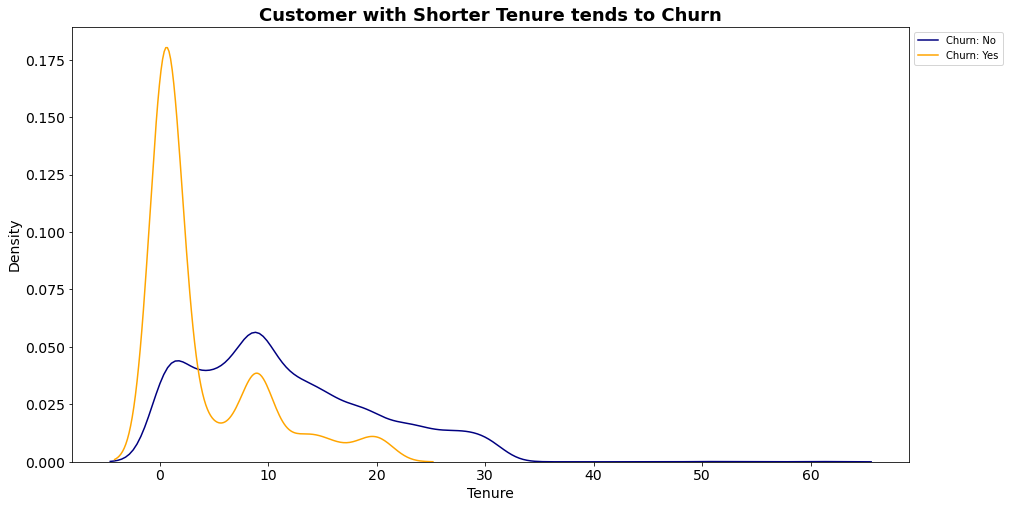

In [463]:
fig, ax = plt.subplots(figsize=(15, 8))

sns.kdeplot(df_featureinsight[df_featureinsight['Churn'] == 0]['Tenure'].dropna(), color= 'navy', label= 'Churn: No', ax=ax)
sns.kdeplot(df_featureinsight[df_featureinsight['Churn'] == 1]['Tenure'].dropna(), color= 'orange', label= 'Churn: Yes', ax=ax)

ax.set_title('Customer with Shorter Tenure tends to Churn',color='black',fontsize=18,fontweight='bold')
ax.set_ylabel('Density', fontsize=14) # y axis label
ax.set_xlabel('Tenure', fontsize=14) # x axis label
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)
plt.legend(loc='upper left',bbox_to_anchor=(1,1),ncol=1)


ax.annotate('high distribution of users \nthat churn (short tenure), \nvice versa', 
            xy=(2, 0.2), xytext=(20, 0.175), arrowprops=dict(facecolor='steelblue',arrowstyle="->",connectionstyle="arc3,rad=.3"),
           ha='center');

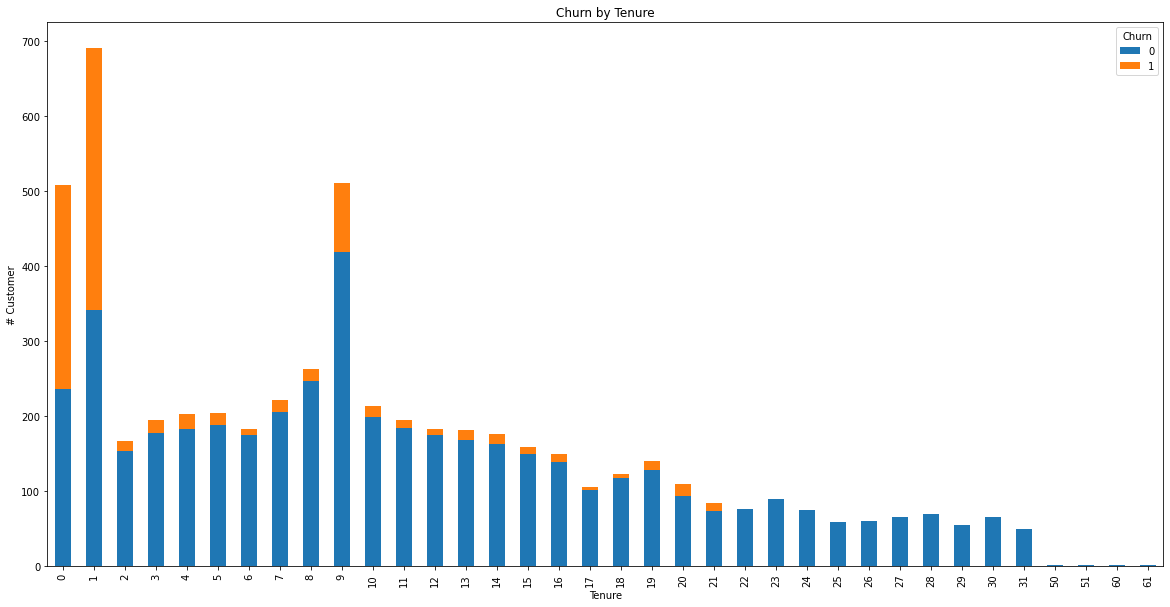

In [464]:
Tenure = pd.crosstab(df_featureinsight["Tenure"], df_featureinsight["Churn"])
Tenure.plot(kind = 'bar', stacked = 'true', title = "Churn by Tenure",figsize=(20,10))
plt.xlabel('Tenure')
plt.ylabel('# Customer')
plt.show()

In [465]:
group_by_complain = df_featureinsight.groupby(['Churn','Complain']).agg({'CustomerID':'nunique'}).reset_index()
group_by_complain['Complain'] = group_by_complain['Complain'].replace({1:'Complain',
                                                                0:'Not Complain'})
group_by_complain

,Churn,Complain,CustomerID
0,0,Not Complain,3586
1,0,Complain,1096
2,1,Not Complain,440
3,1,Complain,508


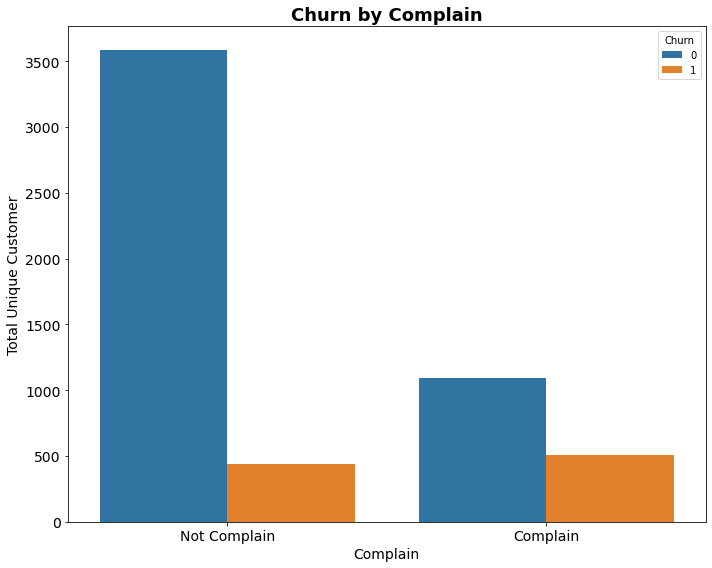

In [466]:
plt.figure(figsize=(10,8))
sns.barplot(y='CustomerID', x='Complain', hue='Churn', data=group_by_complain)

plt.title("Churn by Complain",color='black',fontsize=18,fontweight='bold')
plt.ylabel('Total Unique Customer', fontsize=14) # y axis label
plt.xlabel('Complain', fontsize=14) # x axis label
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)

plt.tight_layout()

In [467]:
group_by_NumberofAddress = df_featureinsight.groupby(['Churn','NumberOfAddress']).agg({'CustomerID':'nunique'}).reset_index()
group_by_NumberofAddress

,Churn,NumberOfAddress,CustomerID
0,0,1,326
1,0,2,1128
2,0,3,1050
3,0,4,523
4,0,5,504
5,0,6,316
6,0,7,192
7,0,8,214
8,0,9,193
9,0,10,159


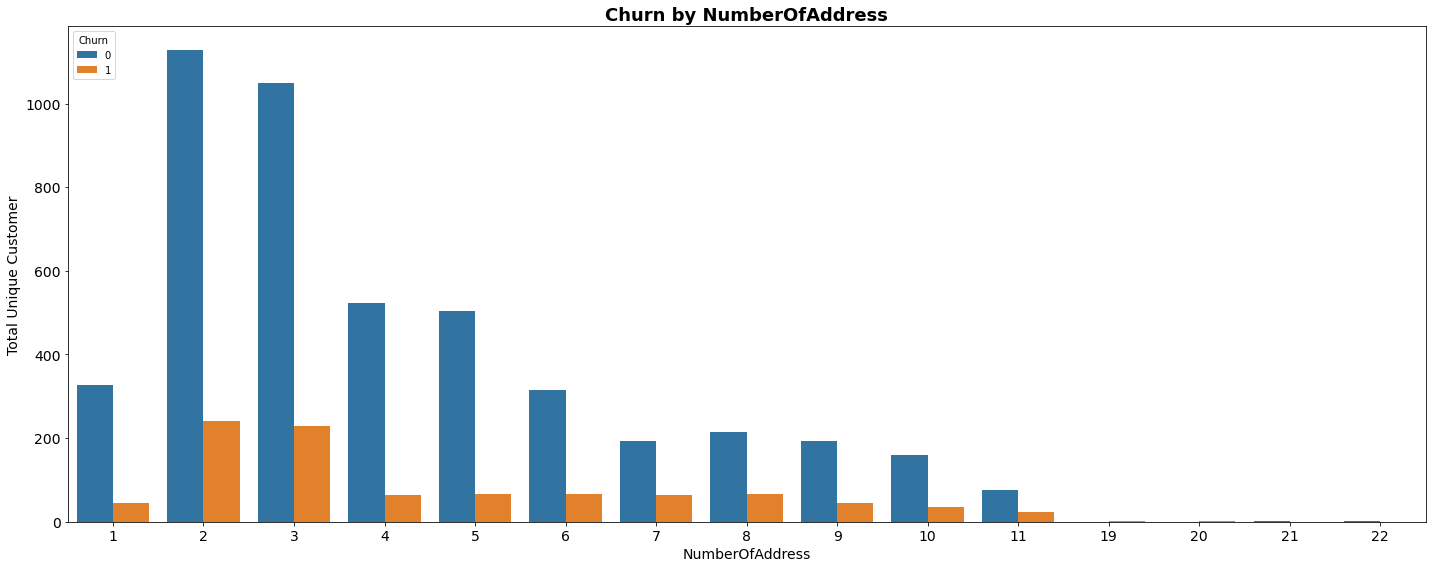

In [468]:
plt.figure(figsize=(20,8))
sns.barplot(y='CustomerID', x='NumberOfAddress', hue='Churn', data=group_by_NumberofAddress)

plt.title("Churn by NumberOfAddress",color='black',fontsize=18,fontweight='bold')
plt.ylabel('Total Unique Customer', fontsize=14) # y axis label
plt.xlabel('NumberOfAddress', fontsize=14) # x axis label
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)

plt.tight_layout()

### Insight Selain Feature Importance

In [469]:
group_by_PreferedOrderCat = df_featureinsight.groupby(['Churn','PreferedOrderCat']).agg({'CustomerID':'nunique'}).reset_index()
group_by_PreferedOrderCat

,Churn,PreferedOrderCat,CustomerID
0,0,Fashion,698
1,0,Grocery,390
2,0,Laptop & Accessory,1840
3,0,Mobile Phone,1510
4,0,Others,244
5,1,Fashion,128
6,1,Grocery,20
7,1,Laptop & Accessory,210
8,1,Mobile Phone,570
9,1,Others,20


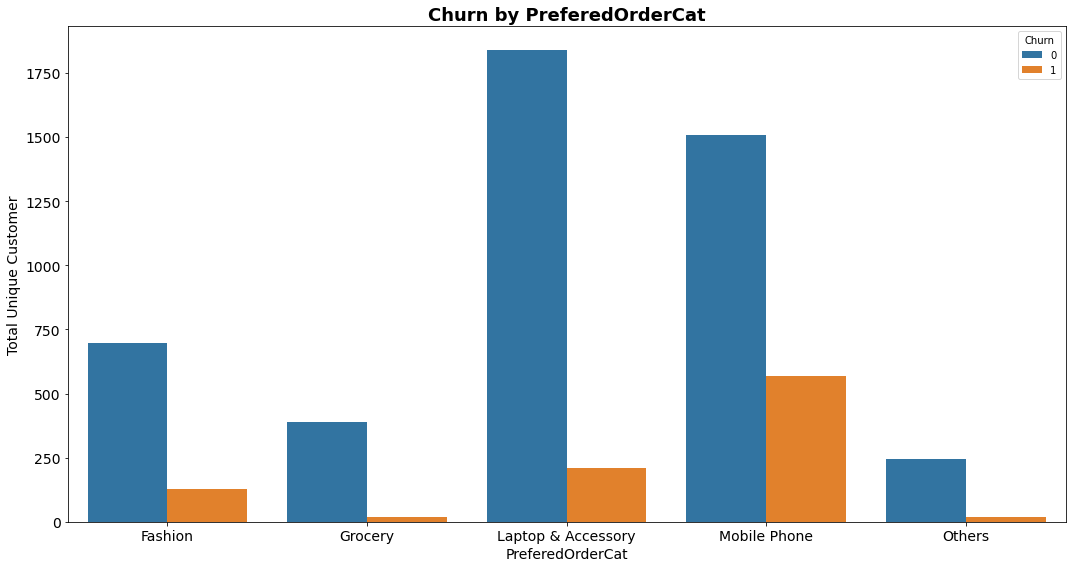

In [470]:
plt.figure(figsize=(15,8))
sns.barplot(y='CustomerID', x='PreferedOrderCat', hue='Churn', data=group_by_PreferedOrderCat)

plt.title("Churn by PreferedOrderCat",color='black',fontsize=18,fontweight='bold')
plt.ylabel('Total Unique Customer', fontsize=14) # y axis label
plt.xlabel('PreferedOrderCat', fontsize=14) # x axis label
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)

plt.tight_layout()

In [471]:
group_by_DaySinceLastOrder = df_featureinsight.groupby(['Churn','DaySinceLastOrder']).agg({'CustomerID':'nunique'}).reset_index()
group_by_DaySinceLastOrder

,Churn,DaySinceLastOrder,CustomerID
0,0,0,326
1,0,1,432
2,0,2,670
3,0,3,1023
4,0,4,373
5,0,5,200
6,0,6,97
7,0,7,382
8,0,8,472
9,0,9,271


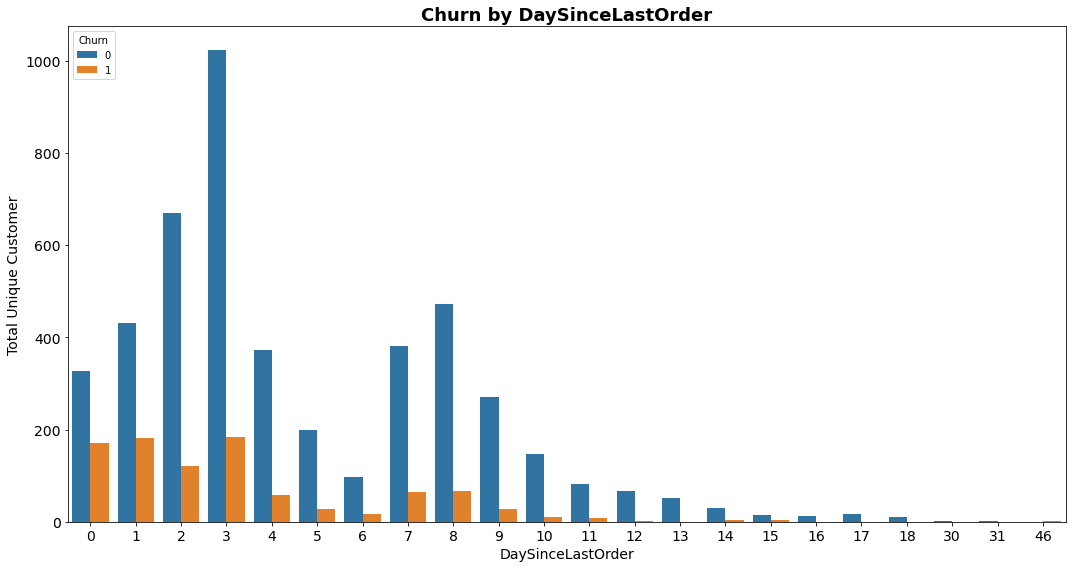

In [472]:
plt.figure(figsize=(15,8))
sns.barplot(y='CustomerID', x='DaySinceLastOrder', hue='Churn', data=group_by_DaySinceLastOrder)

plt.title("Churn by DaySinceLastOrder",color='black',fontsize=18,fontweight='bold')
plt.ylabel('Total Unique Customer', fontsize=14) # y axis label
plt.xlabel('DaySinceLastOrder', fontsize=14) # x axis label
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)

plt.tight_layout()

In [473]:
group_by_WarehouseToHome = df_featureinsight.groupby(['Churn','WarehouseToHome']).agg({'CustomerID':'nunique'}).reset_index()
group_by_WarehouseToHome

,Churn,WarehouseToHome,CustomerID
0,0,5,7
1,0,6,261
2,0,7,340
3,0,8,386
4,0,9,479
...,...,...,...
61,1,32,18
62,1,33,12
63,1,34,10
64,1,35,14


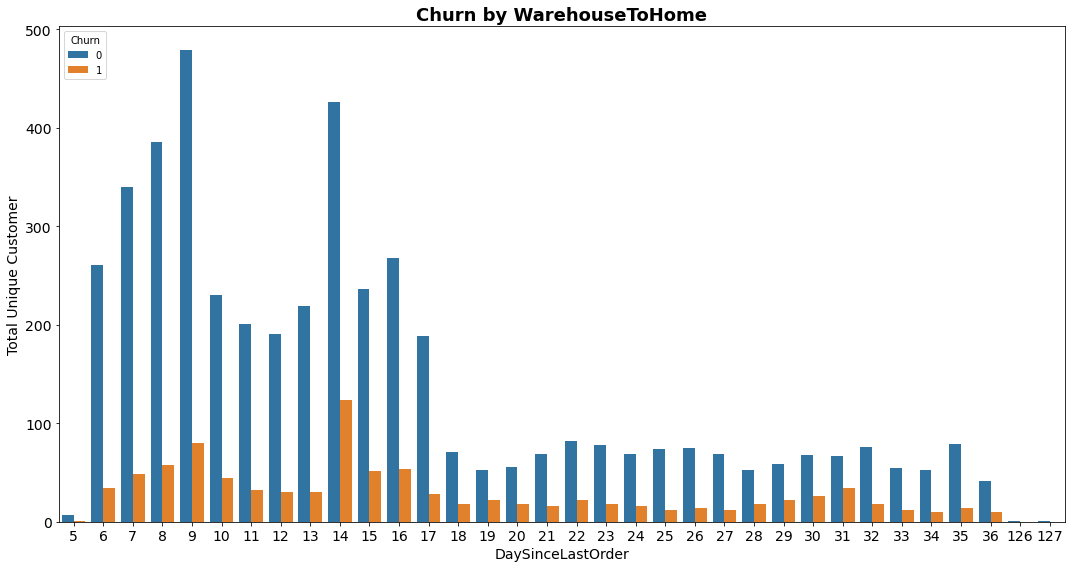

In [474]:
plt.figure(figsize=(15,8))
sns.barplot(y='CustomerID', x='WarehouseToHome', hue='Churn', data=group_by_WarehouseToHome)

plt.title("Churn by WarehouseToHome",color='black',fontsize=18,fontweight='bold')
plt.ylabel('Total Unique Customer', fontsize=14) # y axis label
plt.xlabel('DaySinceLastOrder', fontsize=14) # x axis label
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)

plt.tight_layout()

In [475]:
group_by_CityTier = df_featureinsight.groupby(['Churn','CityTier']).agg({'CustomerID':'nunique'}).reset_index()
group_by_CityTier

,Churn,CityTier,CustomerID
0,0,1,3134
1,0,2,194
2,0,3,1354
3,1,1,532
4,1,2,48
5,1,3,368


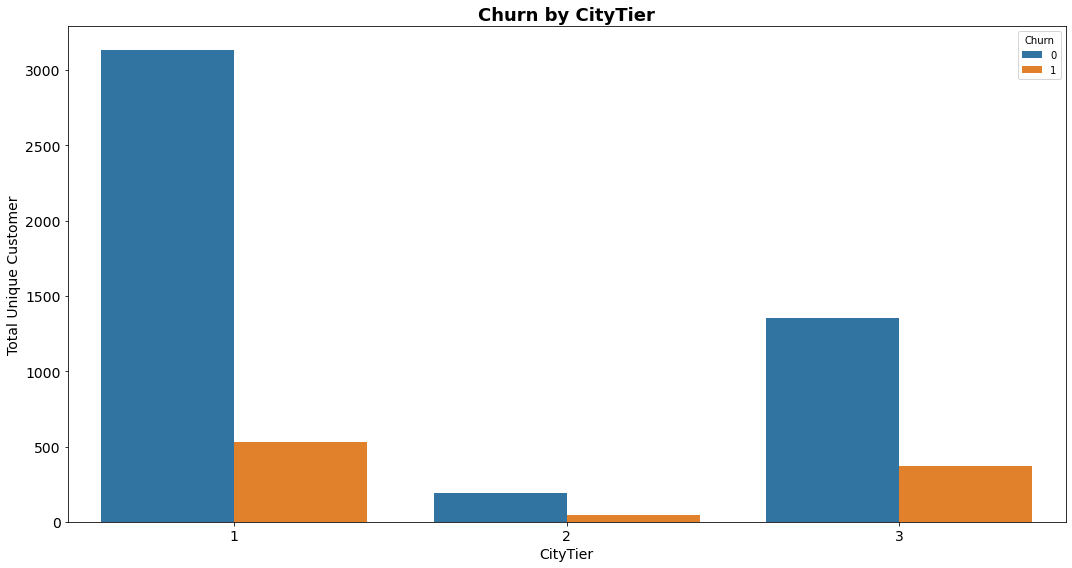

In [476]:
plt.figure(figsize=(15,8))
sns.barplot(y='CustomerID', x='CityTier', hue='Churn', data=group_by_CityTier)

plt.title("Churn by CityTier",color='black',fontsize=18,fontweight='bold')
plt.ylabel('Total Unique Customer', fontsize=14) # y axis label
plt.xlabel('CityTier', fontsize=14) # x axis label
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)

plt.tight_layout()

In [477]:
group_by_SatisfactionScore = df_featureinsight.groupby(['Churn','SatisfactionScore']).agg({'CustomerID':'nunique'}).reset_index()
group_by_SatisfactionScore

,Churn,SatisfactionScore,CustomerID
0,0,1,1030
1,0,2,512
2,0,3,1406
3,0,4,890
4,0,5,844
5,1,1,134
6,1,2,74
7,1,3,292
8,1,4,184
9,1,5,264


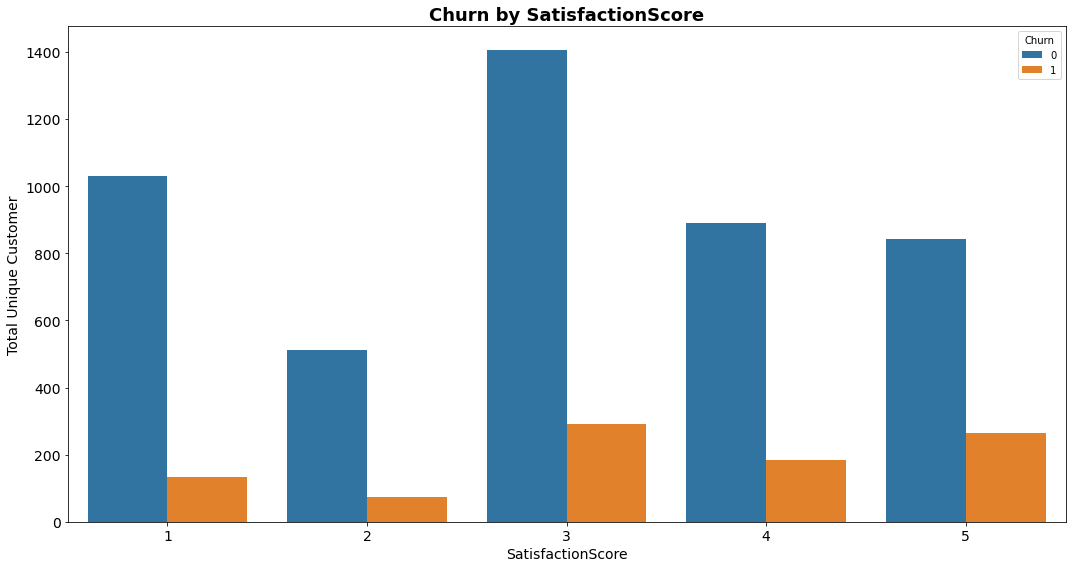

In [478]:
plt.figure(figsize=(15,8))
sns.barplot(y='CustomerID', x='SatisfactionScore', hue='Churn', data=group_by_SatisfactionScore)

plt.title("Churn by SatisfactionScore",color='black',fontsize=18,fontweight='bold')
plt.ylabel('Total Unique Customer', fontsize=14) # y axis label
plt.xlabel('SatisfactionScore', fontsize=14) # x axis label
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)

plt.tight_layout()

In [484]:
group_by_HourSpendOnApp = df_featureinsight.groupby(['Churn','HourSpendOnApp']).agg({'CustomerID':'nunique'}).reset_index()
group_by_HourSpendOnApp

,Churn,HourSpendOnApp,CustomerID
0,0,0,3
1,0,1,35
2,0,2,1239
3,0,3,2424
4,0,4,978
5,0,5,3
6,1,2,232
7,1,3,518
8,1,4,198


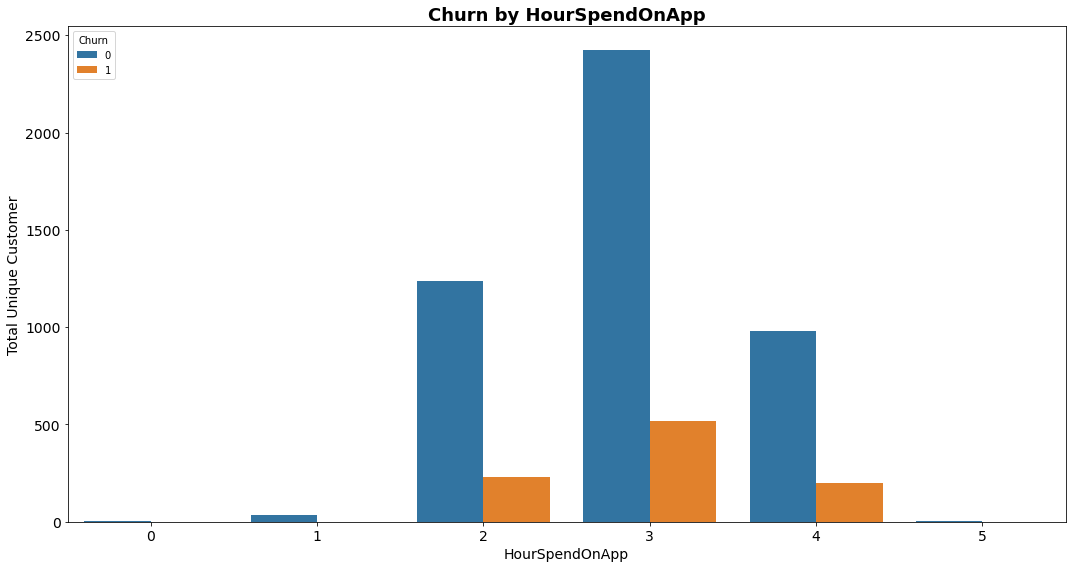

In [487]:
plt.figure(figsize=(15,8))
sns.barplot(y='CustomerID', x='HourSpendOnApp', hue='Churn', data=group_by_HourSpendOnApp)

plt.title("Churn by HourSpendOnApp",color='black',fontsize=18,fontweight='bold')
plt.ylabel('Total Unique Customer', fontsize=14) # y axis label
plt.xlabel('HourSpendOnApp', fontsize=14) # x axis label
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)

plt.tight_layout()

In [488]:
group_by_Gender = df_featureinsight.groupby(['Churn','Gender']).agg({'CustomerID':'nunique'}).reset_index()
group_by_Gender

,Churn,Gender,CustomerID
0,0,Female,1898
1,0,Male,2784
2,1,Female,348
3,1,Male,600


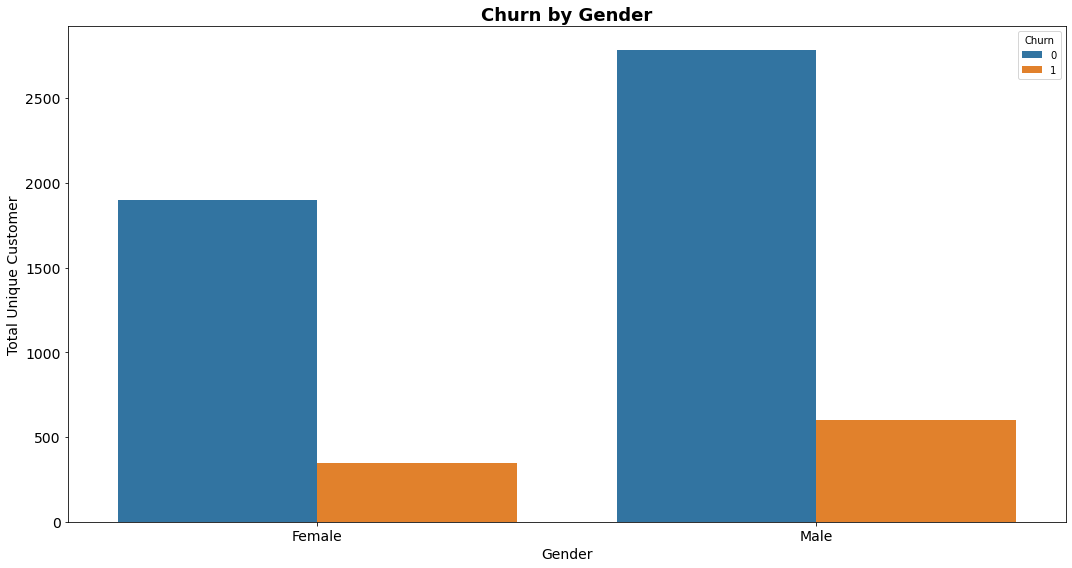

In [490]:
plt.figure(figsize=(15,8))
sns.barplot(y='CustomerID', x='Gender', hue='Churn', data=group_by_Gender)

plt.title("Churn by Gender",color='black',fontsize=18,fontweight='bold')
plt.ylabel('Total Unique Customer', fontsize=14) # y axis label
plt.xlabel('Gender', fontsize=14) # x axis label
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)

plt.tight_layout()

In [495]:
group_by_PreferredPaymentMode = df_featureinsight.groupby(['Churn','PreferredPaymentMode']).agg({'CustomerID':'nunique'}).reset_index()
group_by_PreferredPaymentMode

,Churn,PreferredPaymentMode,CustomerID
0,0,Cash on Delivery,386
1,0,Credit Card,1522
2,0,Debit Card,1958
3,0,E wallet,474
4,0,UPI,342
5,1,Cash on Delivery,128
6,1,Credit Card,252
7,1,Debit Card,356
8,1,E wallet,140
9,1,UPI,72


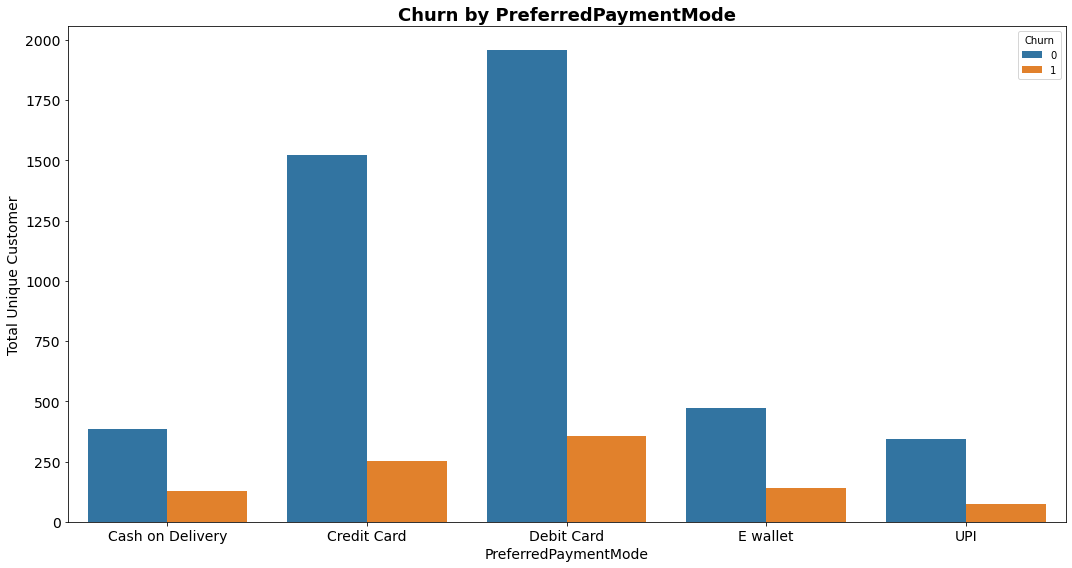

In [496]:
plt.figure(figsize=(15,8))
sns.barplot(y='CustomerID', x='PreferredPaymentMode', hue='Churn', data=group_by_PreferredPaymentMode)

plt.title("Churn by PreferredPaymentMode",color='black',fontsize=18,fontweight='bold')
plt.ylabel('Total Unique Customer', fontsize=14) # y axis label
plt.xlabel('PreferredPaymentMode', fontsize=14) # x axis label
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)

plt.tight_layout()

In [498]:
group_by_MaritalStatus = df_featureinsight.groupby(['Churn','MaritalStatus']).agg({'CustomerID':'nunique'}).reset_index()
group_by_MaritalStatus

,Churn,MaritalStatus,CustomerID
0,0,Divorced,724
1,0,Married,2642
2,0,Single,1316
3,1,Divorced,124
4,1,Married,344
5,1,Single,480


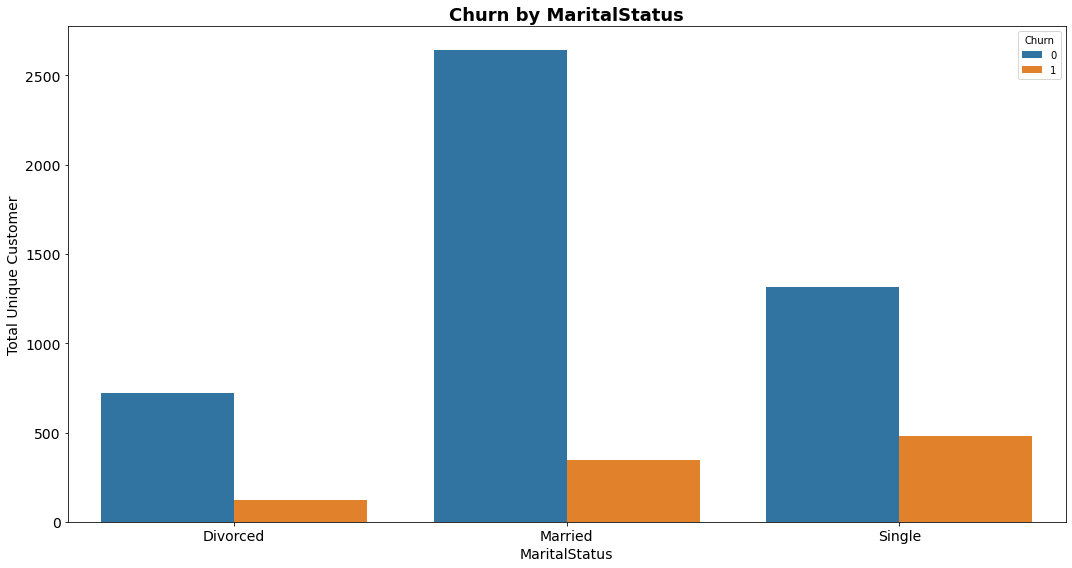

In [499]:
plt.figure(figsize=(15,8))
sns.barplot(y='CustomerID', x='MaritalStatus', hue='Churn', data=group_by_MaritalStatus)

plt.title("Churn by MaritalStatus",color='black',fontsize=18,fontweight='bold')
plt.ylabel('Total Unique Customer', fontsize=14) # y axis label
plt.xlabel('MaritalStatus', fontsize=14) # x axis label
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)

plt.tight_layout()

In [500]:
group_by_CouponUsed = df_featureinsight.groupby(['Churn','CouponUsed']).agg({'CustomerID':'nunique'}).reset_index()
group_by_CouponUsed

,Churn,CouponUsed,CustomerID
0,0,0,844
1,0,1,1975
2,0,2,1061
3,0,3,281
4,0,4,167
5,0,5,106
6,0,6,90
7,0,7,71
8,0,8,33
9,0,9,11


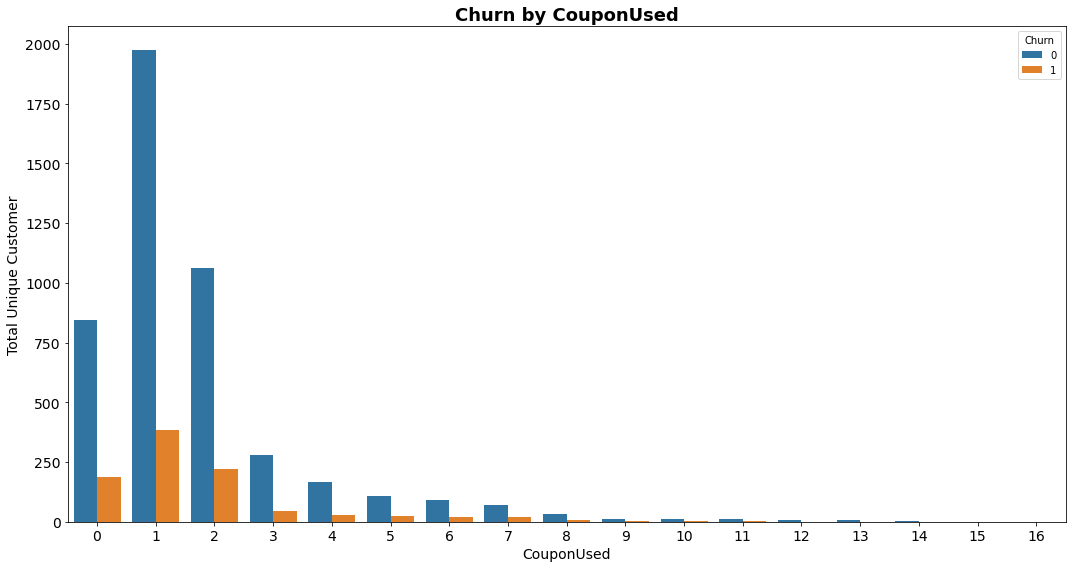

In [501]:
plt.figure(figsize=(15,8))
sns.barplot(y='CustomerID', x='CouponUsed', hue='Churn', data=group_by_CouponUsed)

plt.title("Churn by CouponUsed",color='black',fontsize=18,fontweight='bold')
plt.ylabel('Total Unique Customer', fontsize=14) # y axis label
plt.xlabel('CouponUsed', fontsize=14) # x axis label
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)

plt.tight_layout()

In [503]:
group_by_OrderCount = df_featureinsight.groupby(['Churn','OrderCount']).agg({'CustomerID':'nunique'}).reset_index()
group_by_OrderCount

,Churn,OrderCount,CustomerID
0,0,1,1435
1,0,2,1895
2,0,3,303
3,0,4,176
4,0,5,167
5,0,6,121
6,0,7,164
7,0,8,140
8,0,9,54
9,0,10,28


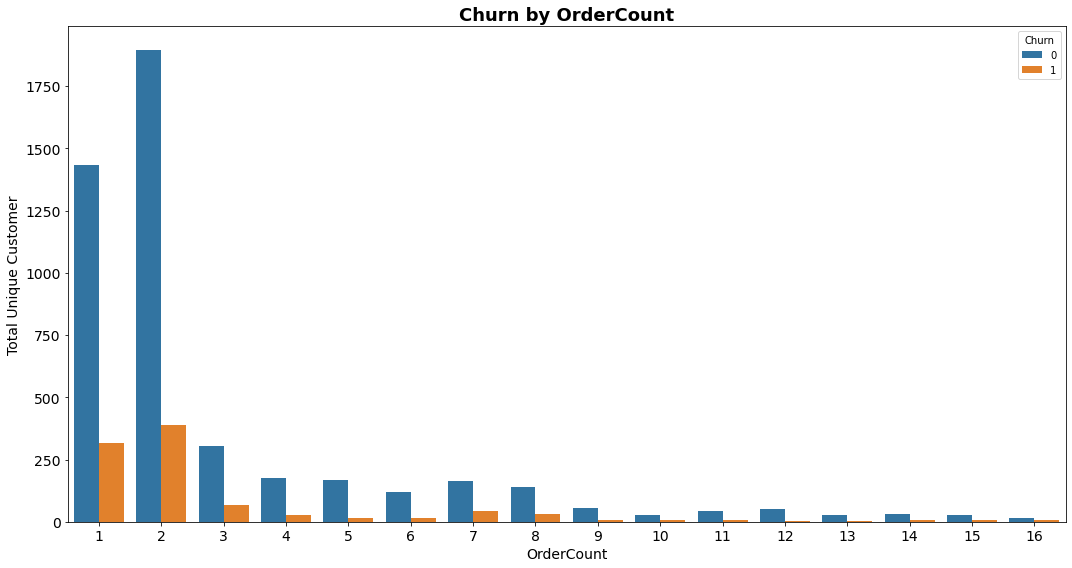

In [504]:
plt.figure(figsize=(15,8))
sns.barplot(y='CustomerID', x='OrderCount', hue='Churn', data=group_by_OrderCount)

plt.title("Churn by OrderCount",color='black',fontsize=18,fontweight='bold')
plt.ylabel('Total Unique Customer', fontsize=14) # y axis label
plt.xlabel('OrderCount', fontsize=14) # x axis label
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)

plt.tight_layout()

In [507]:
group_by_NumberOfDeviceRegistered   = df_featureinsight.groupby(['Churn','NumberOfDeviceRegistered']).agg({'CustomerID':'nunique'}).reset_index()
group_by_NumberOfDeviceRegistered  

,Churn,NumberOfDeviceRegistered,CustomerID
0,0,1,213
1,0,2,250
2,0,3,1445
3,0,4,1985
4,0,5,683
5,0,6,106
6,1,1,22
7,1,2,26
8,1,3,254
9,1,4,392


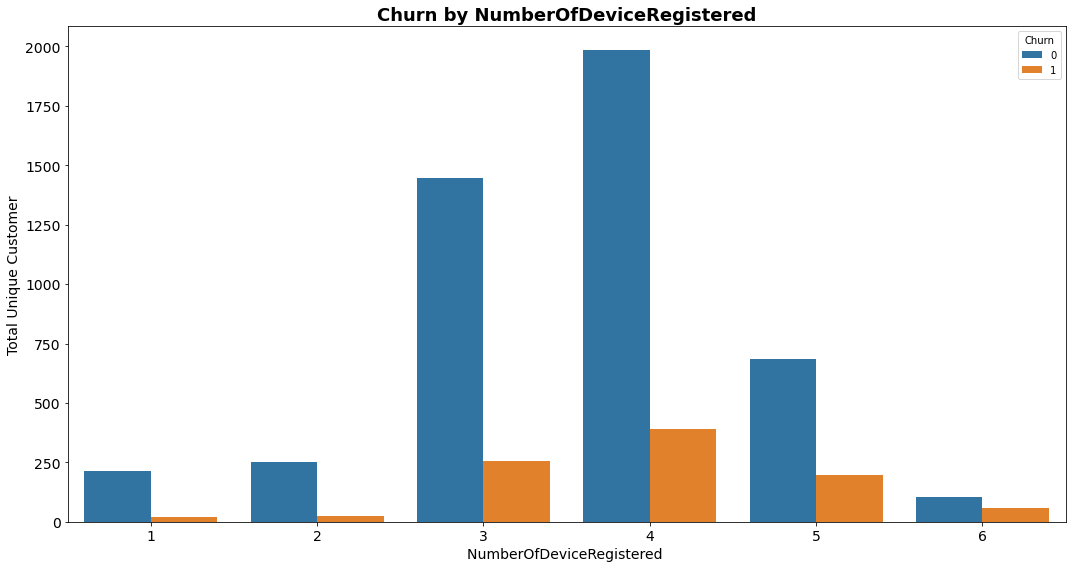

In [508]:
plt.figure(figsize=(15,8))
sns.barplot(y='CustomerID', x='NumberOfDeviceRegistered', hue='Churn', data=group_by_NumberOfDeviceRegistered  )

plt.title("Churn by NumberOfDeviceRegistered",color='black',fontsize=18,fontweight='bold')
plt.ylabel('Total Unique Customer', fontsize=14) # y axis label
plt.xlabel('NumberOfDeviceRegistered ', fontsize=14) # x axis label
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)

plt.tight_layout()

In [511]:
group_by_PreferredLoginDevice  = df_featureinsight.groupby(['Churn','PreferredLoginDevice']).agg({'CustomerID':'nunique'}).reset_index()
group_by_PreferredLoginDevice 

,Churn,PreferredLoginDevice,CustomerID
0,0,Computer,1310
1,0,Mobile Phone,3372
2,1,Computer,324
3,1,Mobile Phone,624


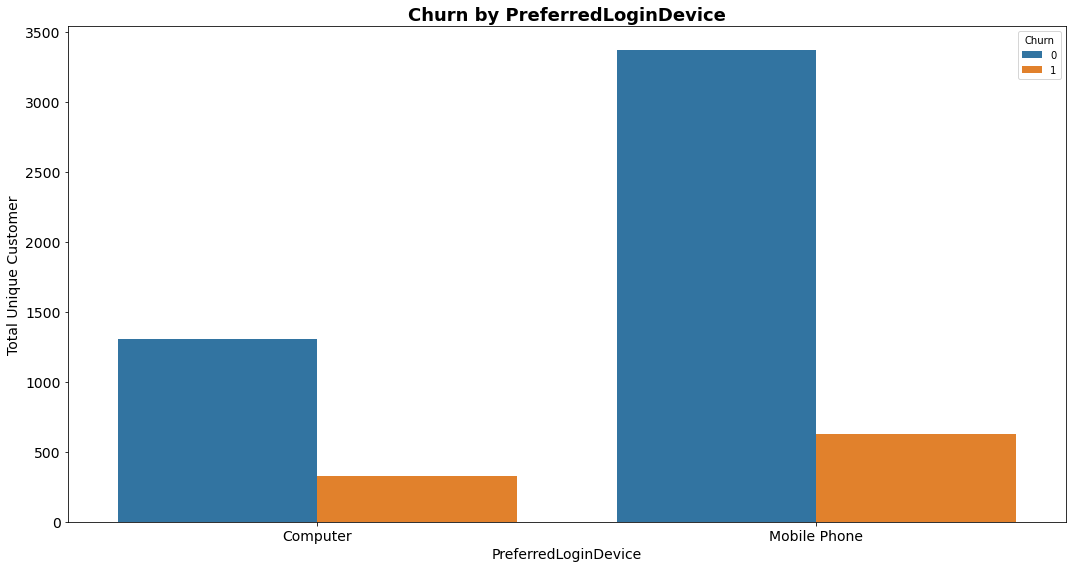

In [512]:
plt.figure(figsize=(15,8))
sns.barplot(y='CustomerID', x='PreferredLoginDevice', hue='Churn', data=group_by_PreferredLoginDevice )

plt.title("Churn by PreferredLoginDevice",color='black',fontsize=18,fontweight='bold')
plt.ylabel('Total Unique Customer', fontsize=14) # y axis label
plt.xlabel('PreferredLoginDevice', fontsize=14) # x axis label
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)

plt.tight_layout()

In [513]:
group_by_OrderAmountHikeFromlastYear  = df_featureinsight.groupby(['Churn','OrderAmountHikeFromlastYear']).agg({'CustomerID':'nunique'}).reset_index()
group_by_OrderAmountHikeFromlastYear 

,Churn,OrderAmountHikeFromlastYear,CustomerID
0,0,11,309
1,0,12,584
2,0,13,613
3,0,14,634
4,0,15,711
5,0,16,269
6,0,17,243
7,0,18,267
8,0,19,267
9,0,20,211


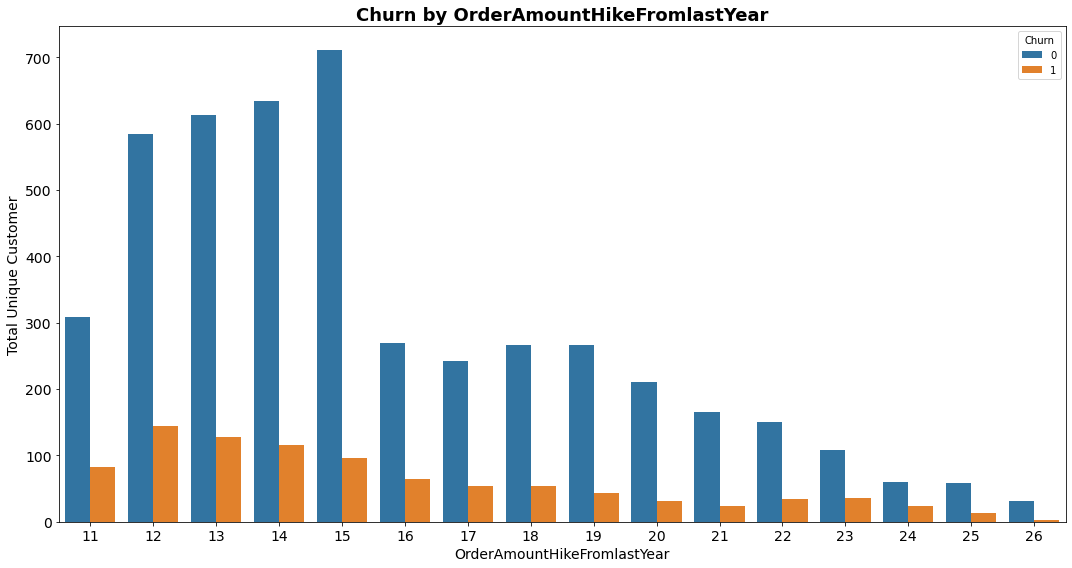

In [514]:
plt.figure(figsize=(15,8))
sns.barplot(y='CustomerID', x='OrderAmountHikeFromlastYear', hue='Churn', data=group_by_OrderAmountHikeFromlastYear)

plt.title("Churn by OrderAmountHikeFromlastYear",color='black',fontsize=18,fontweight='bold')
plt.ylabel('Total Unique Customer', fontsize=14) # y axis label
plt.xlabel('OrderAmountHikeFromlastYear', fontsize=14) # x axis label
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)

plt.tight_layout()